# Bulldozer dataset

This notebook will use a datasets with a large number of columns (>30) and will propose and entire pipeline of treatments.

After this it will focus on the subjects of datasets distribution/randomness and features selection.

In [1]:
import os
import json
import random
from pathlib import Path
from zipfile import ZipFile

In [2]:
import kaggle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [4]:
df = pd.read_feather('tmp/feather')

In [5]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,11.09741,10.950807,9.21034,10.558414,9.305651
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,1.0,1.0,0.0,0.0,2.0
fiModelDesc,949.0,1724.0,330.0,3673.0,4207.0


---

## Crossvalidation and model training

In [6]:
import sklearn.metrics as metrics

def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

### Let's begin

### Model fitting /w log(dependant variable)

In [7]:
X, y = df.drop('SalePrice', axis=1), df.SalePrice.values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [9]:
X_train.shape, type(X_train), y_train.shape, type(y_train)

((320900, 36), pandas.core.frame.DataFrame, (320900,), numpy.ndarray)

In [10]:
y_train = y_train.reshape(-1, 1)

In [11]:
y_test = y_test.reshape(-1, 1)

In [12]:
m = RandomForestRegressor(n_jobs=-1)

In [13]:
%time m.fit(X_train, y_train)

<timed eval>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: user 8min 55s, sys: 3.9 s, total: 8min 59s
Wall time: 1min 15s


RandomForestRegressor(n_jobs=-1)

In [14]:
m.score(X_train, y_train)

0.9863208064566023

In [15]:
preds = m.predict(X_test)

In [16]:
regression_results(y_test, preds)

explained_variance:  0.9022
mean_squared_log_error:  0.0004
r2:  0.9022
MAE:  0.154
MSE:  0.0471
RMSE:  0.2171


The base results are actually not bad, still if there's a little overfit !

### Log + shuffling

In [17]:
X, y = df.drop('SalePrice', axis=1), df.SalePrice.values

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [19]:
X_train.shape, type(X_train), y_train.shape, type(y_train)

((320900, 36), pandas.core.frame.DataFrame, (320900,), numpy.ndarray)

In [20]:
y_train = y_train.reshape(-1, 1)

In [21]:
y_test = y_test.reshape(-1, 1)

In [22]:
m = RandomForestRegressor(n_jobs=-1)

In [23]:
%time m.fit(X_train, y_train)

<timed eval>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: user 8min 53s, sys: 3.71 s, total: 8min 56s
Wall time: 1min 17s


RandomForestRegressor(n_jobs=-1)

In [24]:
m.score(X_train, y_train)

0.9863907182909847

In [25]:
preds = m.predict(X_test)

In [26]:
regression_results(y_test, preds)

explained_variance:  0.9048
mean_squared_log_error:  0.0004
r2:  0.9047
MAE:  0.1526
MSE:  0.046
RMSE:  0.2145


It's just a little bit better, maybe we should try to get a representative part of the dataset or selecting meaningful features ?

---

### Feature selection

#### Basic first try
Let's try to select the most usefull features with an automated approach

In [27]:
X_train.shape

(320900, 36)

In [28]:
minimal_df_size = int(len(X_train)/100); minimal_df_size

3209

In [29]:
# prepare bootstrap sample
X_train_boot = resample(X_train, replace=True, n_samples=minimal_df_size, random_state=1)
X_train_boot.shape

(3209, 36)

In [30]:
# prepare bootstrap sample
y_train_boot = resample(y_train, replace=True, n_samples=minimal_df_size, random_state=1)
y_train_boot.shape

(3209, 1)

In [31]:
# from sklearn.feature_selection import SequentialFeatureSelector

# #Selecting the Best important features according to RandomForestRegressor
# sfs_selector = SequentialFeatureSelector(estimator=RandomForestRegressor(), 
#                                         n_features_to_select=10,
#                                         cv=4,
#                                         direction ='backward')

# sfs_selector.fit(X_train_boot, y_train_boot)
# X.columns[sfs_selector.get_support()]

We try boostraping with the previous method of feature selection but it doesen't work.

Even with a very tiny part of our dataset (0.8% random parts from the original set) the computation take too much time (more than 10mins on an 8 core CPU).

#### Fastai approach of feature Importance

In [32]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_})

def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [33]:
%time fi = rf_feat_importance(m, X_train); fi

CPU times: user 514 ms, sys: 6.45 ms, total: 520 ms
Wall time: 87 ms


,cols,imp
0,SalesID,0.034048
1,MachineID,0.014505
2,ModelID,0.081906
3,datasource,0.000659
4,auctioneerID,0.005052
5,YearMade,0.159864
6,MachineHoursCurrentMeter,0.009411
7,UsageBand,0.002017
8,fiModelDesc,0.058929
9,fiBaseModel,0.041561


This approach is manuel but yet efficient and powerfull !

Let's select the most interesting features :

<AxesSubplot:ylabel='cols'>

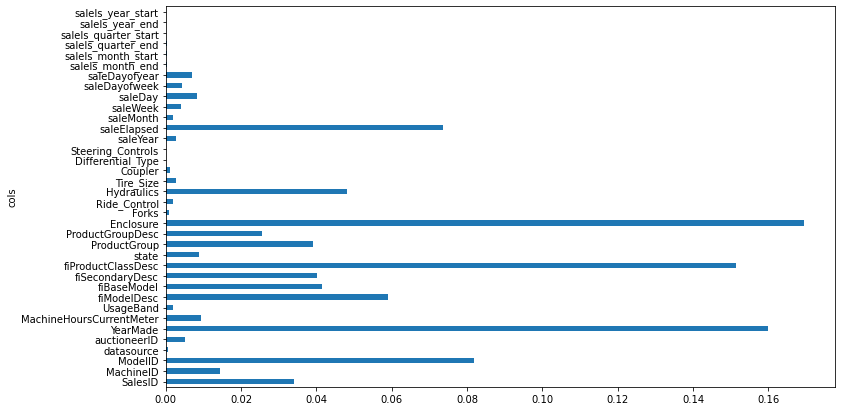

In [34]:
plot_fi(fi)

In [35]:
fi.shape

(36, 2)

<AxesSubplot:ylabel='cols'>

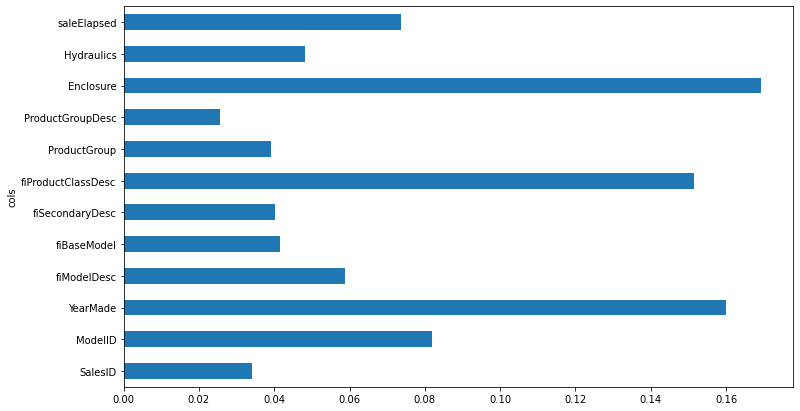

In [36]:
to_keep = fi[fi.imp > 0.025]
plot_fi(to_keep)

In [37]:
to_keep.shape

(12, 2)

---

## Optimizing training time and results with features importance and bagging

In [38]:
minimal_df_size = int(len(X_train)/100); minimal_df_size

3209

In [39]:
# prepare bootstrap sample
X_train_boot = resample(X_train.copy(), n_samples=minimal_df_size, random_state=1)
y_train_boot = resample(y_train.copy(), n_samples=minimal_df_size, random_state=1)

X_train_boot.shape, y_train_boot.shape

((3209, 36), (3209, 1))

In [40]:
# prepare bootstrap sample
X_test_boot = resample(X_test.copy(), n_samples=minimal_df_size, random_state=1)
y_test_boot = resample(y_test.copy(), n_samples=minimal_df_size, random_state=1)

X_train_boot.shape, y_train_boot.shape

((3209, 36), (3209, 1))

In [41]:
X_train

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start
383368,4303470,248990,1169,172,1.0,2005,4370.0,2.0,546.0,185.0,...,7,15,1,46,False,False,False,False,False,False
233859,1730237,1398976,9113,132,1.0,1985,3478.0,2.0,4756.0,1848.0,...,11,15,3,74,False,False,False,False,False,False
56898,1312908,1365560,3414,132,1.0,1986,4971.0,2.0,347.0,116.0,...,50,13,0,347,False,False,False,False,False,False
208732,1659566,1305163,4991,132,1.0,1999,495.0,2.0,1015.0,310.0,...,41,9,1,282,False,False,False,False,False,False
266409,1802998,1376920,9506,132,1.0,1000,2000.0,1.0,576.0,191.0,...,11,14,2,73,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73349,1359824,1422787,3406,132,1.0,1988,4455.0,1.0,318.0,107.0,...,49,7,1,341,False,False,False,False,False,False
371403,2646355,1924827,4606,149,99.0,2000,0.0,1.0,496.0,174.0,...,4,29,5,29,False,False,False,False,False,False
312201,2273241,350696,3537,136,1.0,1994,0.0,1.0,735.0,242.0,...,2,12,5,12,False,False,False,False,False,False
267336,1804322,1423136,9563,132,2.0,1996,533.0,1.0,1598.0,474.0,...,50,15,5,349,False,False,False,False,False,False


Let's compare our multiple set :

- (line, columns)

In [42]:
X_train.shape

(320900, 36)

In [43]:
X_train[to_keep.cols].shape

(320900, 12)

In [44]:
X_train_boot[to_keep.cols].shape

(3209, 12)

How fast a model is trained now ? Let's see some numbers !

In [45]:
X_train_mini = X_train_boot[to_keep.cols]; X_train_mini.shape

(3209, 12)

In [46]:
y_train_mini = y_train_boot[:]; y_train_mini.shape

(3209, 1)

In [47]:
m = RandomForestRegressor(n_jobs=-1)

In [48]:
%time m.fit(X_train_mini, y_train_mini)

<timed eval>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: user 1.45 s, sys: 23.3 ms, total: 1.47 s
Wall time: 288 ms


RandomForestRegressor(n_jobs=-1)

In [49]:
m.score(X_test_boot[to_keep.cols], y_test_boot[:])

0.7638063092361757

In [50]:
preds = m.predict(X_test_boot[to_keep.cols])

In [51]:
regression_results(y_test_boot, preds)

explained_variance:  0.7645
mean_squared_log_error:  0.0009
r2:  0.7638
MAE:  0.2561
MSE:  0.1158
RMSE:  0.3402
